In [1]:
import tensorflow as tf
from tensorflow.keras.utils import get_file
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data preparation
def preprocess_image(image, label, image_size=(224, 224)):
    image = tf.image.resize(image, image_size)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def prepare_dataset(batch_size=32, image_size=(224, 224), test_split=0.2):
    # Download the Imagenette dataset
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz"
    dataset_path = get_file("imagenette2", dataset_url, untar=True)

    # Load the full training dataset
    full_train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + "/train",
        image_size=image_size,
        batch_size=batch_size
    )

    # Split into training and test datasets
    dataset_size = len(full_train_ds)
    test_size = int(dataset_size * test_split)
    train_size = dataset_size - test_size

    train_ds = full_train_ds.take(train_size)
    test_ds = full_train_ds.skip(train_size)

    # Load validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + "/val",
        image_size=image_size,
        batch_size=batch_size
    )

    # Apply preprocessing, caching, and prefetching
    train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, image_size)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, image_size)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: preprocess_image(x, y, image_size)).cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

batch_size = 32
image_size = (224, 224)
train_ds, val_ds, test_ds = prepare_dataset(batch_size=batch_size, image_size=image_size, test_split=0.2)

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


In [3]:
# Gated Linear Unit (GLU) with arctan activation
class GatedLinearUnit(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(GatedLinearUnit, self).__init__()
        self.hidden_dim = hidden_dim
        self.linear = tf.keras.layers.Dense(hidden_dim)
        self.gate = tf.keras.layers.Dense(hidden_dim)

    def call(self, inputs):
        gate = tf.nn.gelu(self.gate(inputs))
        linear = tf.nn.relu(self.linear(inputs))
        return gate * linear

In [4]:
# Transformer Encoder with GLU
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, ff_hidden_dim, dropout_rate):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = tf.keras.Sequential([
            GatedLinearUnit(ff_hidden_dim),  # Using GLU here
            tf.keras.layers.Dense(embedding_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        # Multi-head self-attention
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network with GLU
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [5]:
# Vision Transformer
class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, num_classes, embedding_dim, num_heads, num_layers, ff_hidden_dim, dropout_rate):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.embedding_dim = embedding_dim

        # Patch embedding layer
        self.patch_embedding = tf.keras.layers.Conv2D(embedding_dim, patch_size, strides=patch_size, padding='valid')

        # Positional embeddings using sine and cosine
        self.pos_embedding = self.create_sin_cos_positional_embeddings(self.num_patches, embedding_dim)

        # Prepend CLS token
        self.cls_token = tf.Variable(tf.zeros([1, 1, embedding_dim]), trainable=True)

        # Transformer encoder layers with GLU
        self.transformer_layers = [
            TransformerEncoderLayer(embedding_dim, num_heads, ff_hidden_dim, dropout_rate)
            for _ in range(num_layers)
        ]

        # Classification head
        self.cls_head = tf.keras.Sequential([
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

    def create_sin_cos_positional_embeddings(self, num_patches, embedding_dim):
        position = np.arange(num_patches)[:, np.newaxis]
        div_term = np.exp(np.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))

        pos_encoding = np.zeros((num_patches, embedding_dim))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)

        return tf.constant(pos_encoding[np.newaxis, :, :], dtype=tf.float32)

    def call(self, inputs, training=False):
        # Extract patches and embed
        patches = self.patch_embedding(inputs)
        patches = tf.reshape(patches, [-1, self.num_patches, self.embedding_dim])

        # Add positional embeddings
        patches += self.pos_embedding

        # Prepend the CLS token
        batch_size = tf.shape(patches)[0]
        cls_tokens = tf.tile(self.cls_token, [batch_size, 1, 1])
        x = tf.concat([cls_tokens, patches], axis=1)

        # Apply transformer encoder layers
        for layer in self.transformer_layers:
            x = layer(x, training=training)

        # Extract CLS token and apply classification head
        cls_token = x[:, 0]  # CLS token
        return self.cls_head(cls_token)

In [6]:
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PrintMetricsCallback, self).__init__()
        self.best_epoch = 0
        self.best_val_loss = float('inf')
        self.best_metrics = {}

    def on_epoch_end(self, epoch, logs=None):
        # Print the metrics after each epoch
        print(f"\nEpoch {epoch + 1}:")
        print(f"  Training Loss: {logs['loss']:.4f}")
        print(f"  Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f}")
        print(f"  Validation Accuracy: {logs['val_accuracy']:.4f}")
        print('-' * 10)

        # Track the best epoch based on validation loss
        val_loss = logs.get('val_loss')
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_epoch = epoch
            self.best_metrics = logs

In [7]:
# Initialize and compile the model
model = VisionTransformer(
    image_size=224,
    patch_size=16,
    num_classes=10,
    embedding_dim=48,
    num_heads=12,
    num_layers=12,
    ff_hidden_dim=3072,
    dropout_rate=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Create an instance of the PrintMetricsCallback
print_metrics_callback = PrintMetricsCallback()

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stopping, reduce_lr_on_plateau, print_metrics_callback]
)
# After training, retrieve the best epoch metrics
best_epoch = print_metrics_callback.best_epoch
best_metrics = print_metrics_callback.best_metrics

# Evaluate the model on the test dataset at the best epoch
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the best epoch along with the metrics
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"  Training Loss: {best_metrics['loss']:.4f}")
print(f"  Training Accuracy: {best_metrics['accuracy']:.4f}")
print(f"  Validation Loss: {best_metrics['val_loss']:.4f}")
print(f"  Validation Accuracy: {best_metrics['val_accuracy']:.4f}")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")

Epoch 1/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1293 - loss: 2.3604
Epoch 1:
  Training Loss: 2.2322
  Training Accuracy: 0.1665
  Validation Loss: 2.0450
  Validation Accuracy: 0.2772
----------
237/237 ━━━━━━━━━━━━━━━━━━━━ 1022s 4s/step - accuracy: 0.1294 - loss: 2.3599 - val_accuracy: 0.2772 - val_loss: 2.0450 - learning_rate: 1.0000e-04
Epoch 2/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2930 - loss: 2.0032
Epoch 2:
  Training Loss: 1.9542
  Training Accuracy: 0.3099
  Validation Loss: 1.8261
  Validation Accuracy: 0.3631
----------
237/237 ━━━━━━━━━━━━━━━━━━━━ 830s 3s/step - accuracy: 0.2931 - loss: 2.0030 - val_accuracy: 0.3631 - val_loss: 1.8261 - learning_rate: 1.0000e-04
Epoch 3/1000
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3809 - loss: 1.7775
Epoch 3:
  Training Loss: 1.7585
  Training Accuracy: 0.3884
  Validation Loss: 1.6834
  Validation Accuracy: 0.4311
----------
237/237 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.3809 -

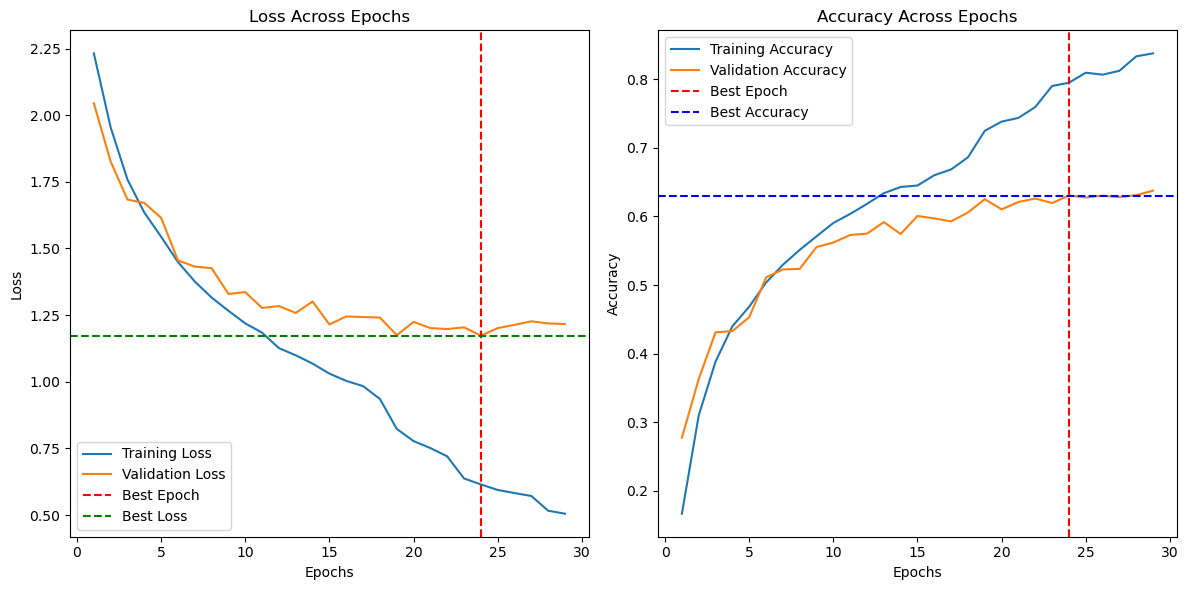

In [8]:
# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the best epoch and metrics from the callback
best_epoch = print_metrics_callback.best_epoch
best_train_loss = print_metrics_callback.best_metrics['loss']
best_train_accuracy = print_metrics_callback.best_metrics['accuracy']
best_val_loss = print_metrics_callback.best_metrics['val_loss']
best_val_accuracy = print_metrics_callback.best_metrics['val_accuracy']

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', label=f'Best Epoch')
plt.axhline(y=best_val_loss, color='g', linestyle='--', label=f'Best Loss')
plt.title('Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', label=f'Best Epoch')
plt.axhline(y=best_val_accuracy, color='b', linestyle='--', label=f'Best Accuracy')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()